# Section 5.1-5.2: 
## Analysis of fitness for ind, sm, and ilp
### Evaluation measurements boxplots

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
import os

In [2]:
INPUT_PATH = "../data/bpm_25/8fts_3miners_ind_ilp_sm1_benchmark.csv"
data = pd.read_csv(INPUT_PATH)

data[["fitness_sm1", "precision_sm1", "fscore_sm1"]] = data[["fitness_sm1", "precision_sm1", "fscore_sm1"]].replace(-1, np.nan)

columns_to_keep = [col for col in data.columns if col.endswith(('ilp', 'inductive', 'sm1'))]+['log']

filtered_data = data[columns_to_keep]
filtered_data = filtered_data.dropna()
print(filtered_data.shape)
filtered_data.head()

(19743, 25)


,benchtime_inductive,cfc_inductive,exectime_inductive,fitness_inductive,fscore_inductive,pnsize_inductive,precision_inductive,size_inductive,fitness_sm1,precision_sm1,...,benchtime_sm1,benchtime_ilp,cfc_ilp,exectime_ilp,fitness_ilp,fscore_ilp,pnsize_ilp,precision_ilp,size_ilp,log
0,3.18,11.0,0.15,0.999920,0.948682,14.0,0.902439,21.0,0.999938,0.902439,...,7.12,2.01,6.0,0.67,0.99997,0.598802,7.0,0.427356,21.0,genEL10000_6413_nan_nan_nan_758_31382_nan_nan
1,10.21,13.0,4.29,0.999942,0.773897,30.0,0.631207,39.0,0.798837,0.866994,...,16.66,10.37,12.0,1.65,0.99998,0.567029,22.0,0.395704,47.0,genEL10001_6413_nan_nan_nan_758_nan_-097_nan
4,50.95,20.0,2.49,0.999927,0.669737,37.0,0.503480,46.0,0.798837,0.866994,...,22.76,10.25,12.0,1.45,0.99998,0.567029,22.0,0.395704,47.0,genEL10003_6413_nan_nan_nan_758_nan_259_nan
7,53.16,13.0,0.48,0.999942,0.773897,30.0,0.631207,39.0,0.798837,0.866994,...,42.24,19.18,12.0,1.70,0.99998,0.567029,22.0,0.395704,47.0,genEL10005_6413_nan_nan_nan_758_nan_615_nan
8,25.81,13.0,0.52,0.999942,0.773897,30.0,0.631207,39.0,0.798837,0.866994,...,19.86,11.11,12.0,1.43,0.99998,0.567029,22.0,0.395704,47.0,genEL10006_6413_nan_nan_nan_758_nan_792_nan


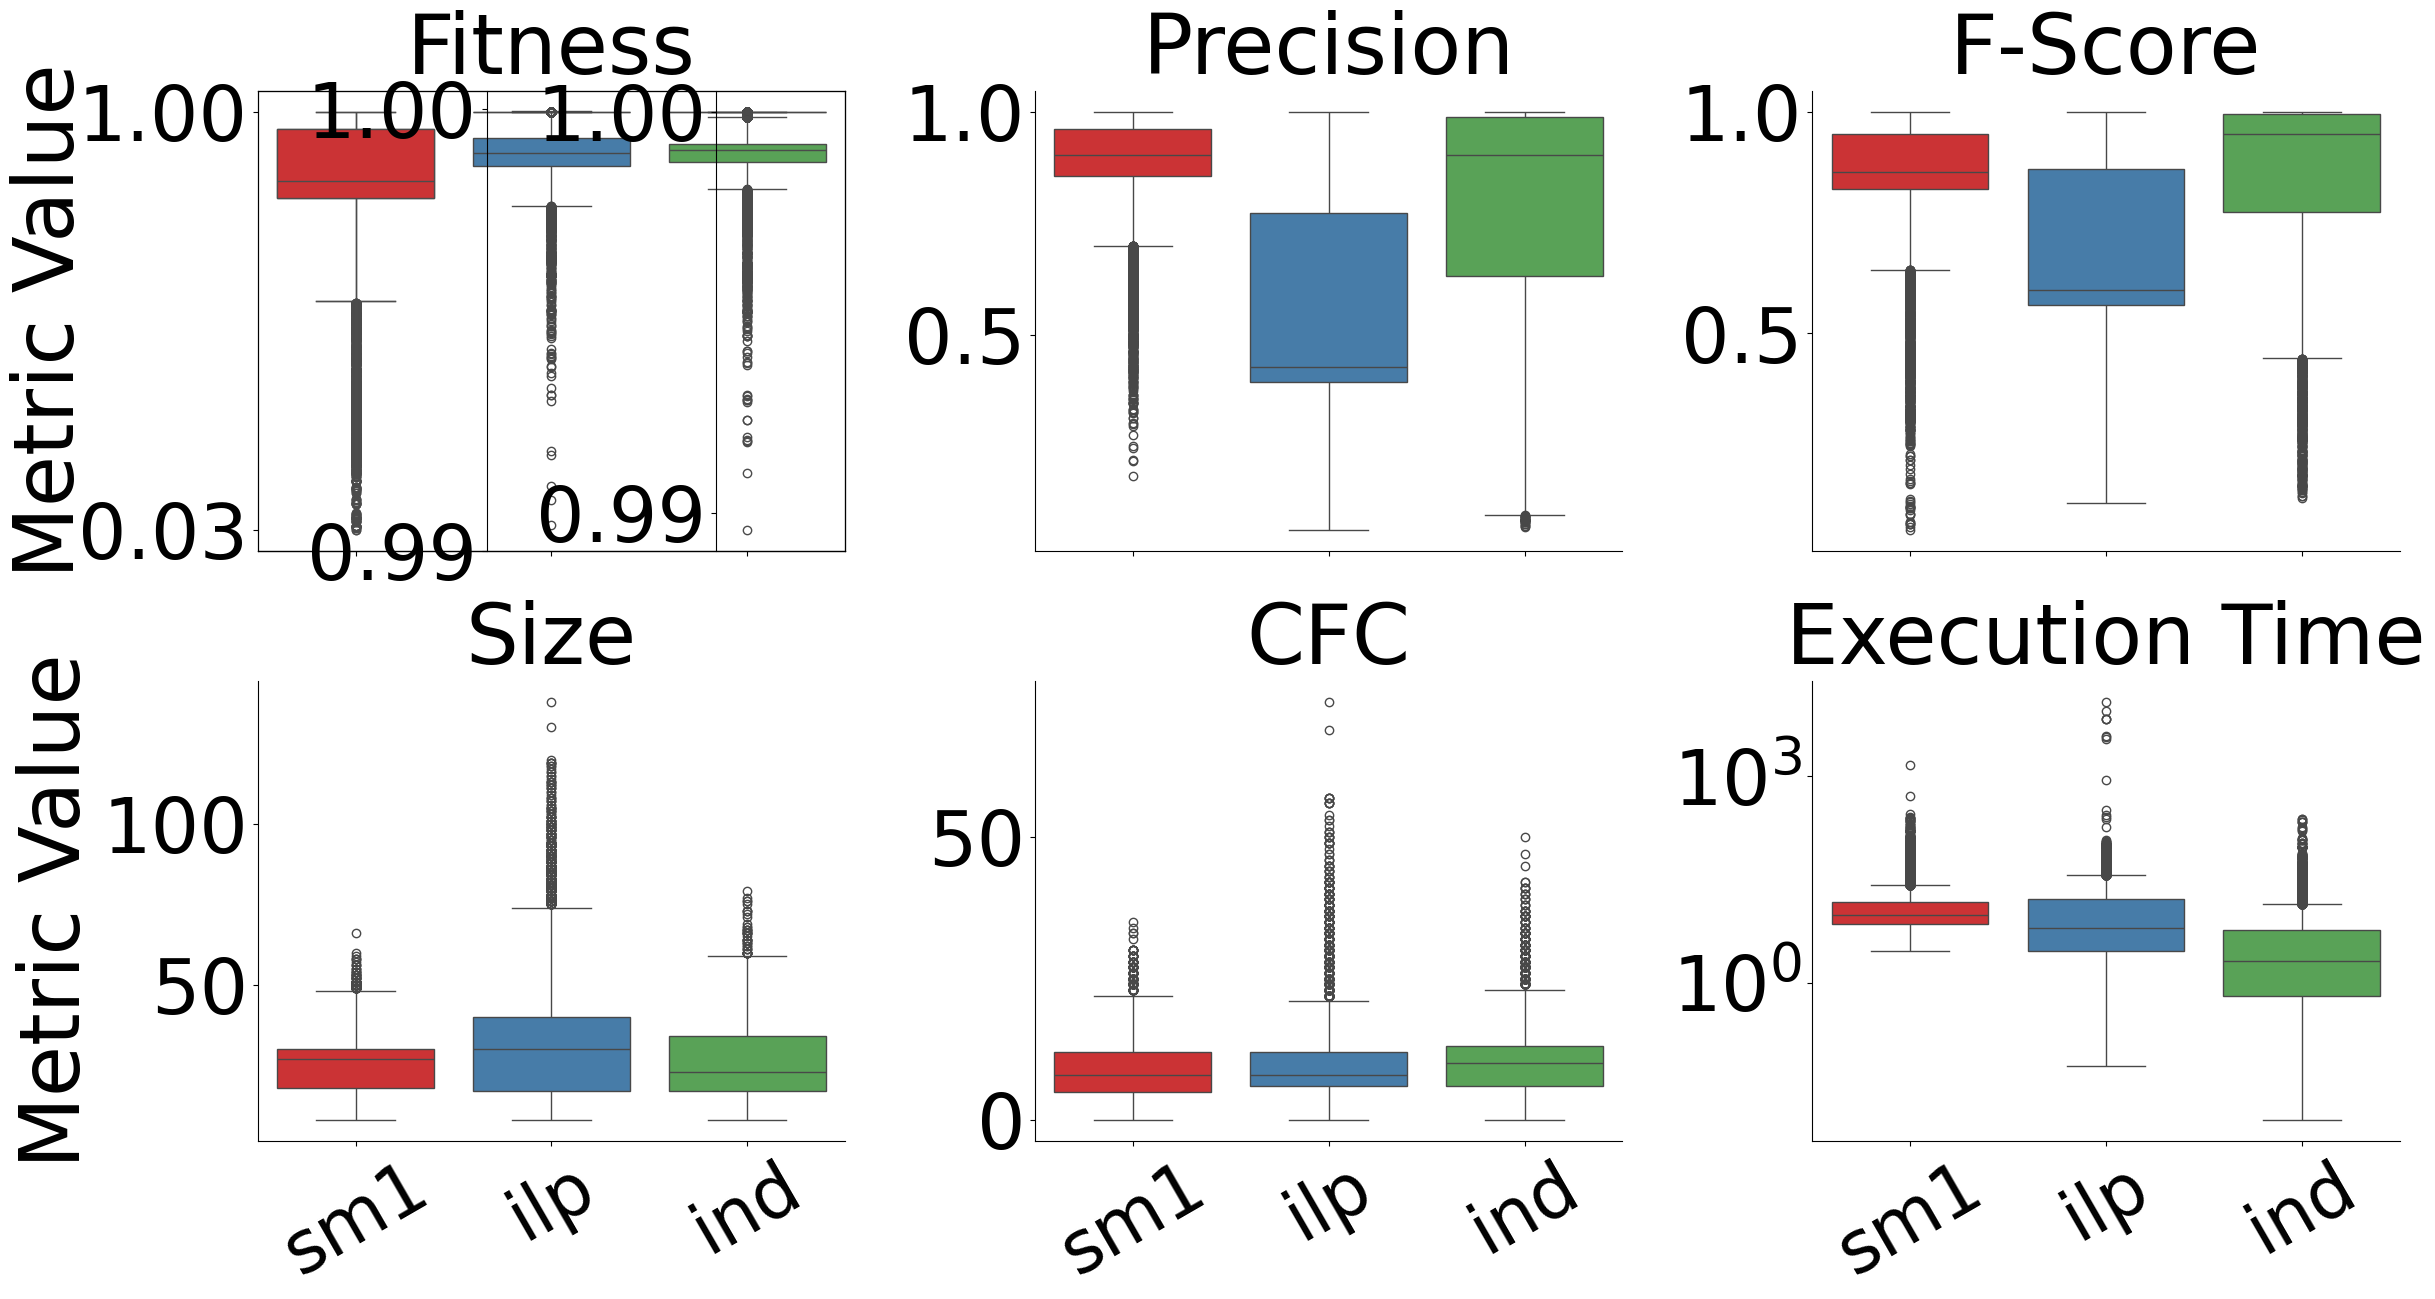

In [3]:
import warnings
warnings.filterwarnings('ignore')

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

FONTSIZE = 60
df = data.copy()

metrics = ['exectime', 'fitness', 'fscore', 'cfc', 'precision', 'size']
algorithms = ['sm1', 'ilp','inductive']

# Prepare a list to store the reshaped data
melted_data = []

# Loop through metrics and algorithms and extract the data
for metric in metrics:
    for algo in algorithms:
        col_name = f'{metric}_{algo}'  # Construct the column name based on metric and algorithm
        if col_name in df.columns:
            melted_data.extend([{
                'Metric': metric,
                'Algorithm': algo,
                'Measurement': value
            } for value in df[col_name].values])  # Extract individual values

# Create the DataFrame from melted_data
filtered_data = pd.DataFrame(melted_data)
filtered_data["Algorithm"] = filtered_data["Algorithm"].str.replace("inductive", "ind", regex=False)
algorithms = ['sm1', 'ilp', 'ind']

# Define the desired order of metrics with improved names
metric_rename = {
    'fitness': 'Fitness',
    'precision': 'Precision',
    'fscore': 'F-Score',
    'size': 'Size',
    'cfc': 'CFC',
    'exectime': 'Execution Time'
}
metric_order = list(metric_rename.keys())

# Calculate the IQR for 'exectime' and filter out the outliers
exectime_data = filtered_data[filtered_data['Metric'] == 'Execution Time']
Q3 = exectime_data['Measurement'].quantile(0.99)
filtered_exectime_data = exectime_data[exectime_data['Measurement'] <= Q3]

# Create a new dataframe excluding the outliers for 'exectime'
filtered_data = filtered_data[filtered_data['Metric'] != 'Execution Time']
filtered_data = pd.concat([filtered_data, filtered_exectime_data])

# Rename metric names for better readability in plots
filtered_data["Metric"] = filtered_data["Metric"].replace(metric_rename)

# Create a FacetGrid with larger subplots for better readability
g = sns.FacetGrid(filtered_data, col="Metric", col_wrap=3, height=7, sharey=False, 
                  col_order=[metric_rename[m] for m in metric_order], aspect=1.2)

# Map the boxplot to the grid
g.map(sns.boxplot, "Algorithm", "Measurement", palette="Set1")

# Apply log scale only to 'Execution Time' and properly format titles
for i, ax in enumerate(g.axes.flat):
    metric_name = ax.get_title().replace("Metric = ", "")  # Remove the prefix manually
    ax.set_title(metric_name, fontsize=FONTSIZE)

    if metric_name == 'Execution Time':
        ax.set_yscale('log')

    # If it's the 'Fitness' plot, split it into three different y-axes for each algorithm
    if metric_name == 'Fitness':
        twin_axes = []  # Store all twin axes
        
        # Get the Set1 palette colors
        palette = sns.color_palette("Set1", n_colors=3)

        for j, algo in enumerate(algorithms):
            algo_data = filtered_data[(filtered_data['Metric'] == 'Fitness') & (filtered_data['Algorithm'] == algo)]
            # Create a new subplot for each algorithm with consistent coloring
            ax2 = ax.twinx()  # Create a twin y-axis
            sns.boxplot(x="Algorithm", y="Measurement", data=algo_data, palette=[palette[j]], ax=ax2)
            
            # Move each twin y-axis outward by a different amount
            offset = -165 * j  # Adjust spacing
            ax2.spines['left'].set_position(('outward', offset))

            # Ensure visibility of all twin y-axes
            ax2.spines['left'].set_visible(True)  # Keep right spine for each
            ax2.yaxis.set_ticks_position('left')  # Keep original tick position
            
            # Reduce overlap by limiting labels
            ax2.set_ylabel('')
            ax.set_ylabel("Metric Value", fontsize=FONTSIZE, labelpad=120)  # Set labelpad to move the label further left
            ax2.tick_params(axis='y', labelsize=FONTSIZE-5)
            
            # Get min and max values for the 'Fitness' data
            min_val = round(algo_data['Measurement'].min(), 4)
            max_val = round(algo_data['Measurement'].max(), 2)

            # Set the y-ticks for the twin axis (show min, max, and some in-between values if needed)
            ax2.set_yticks([min_val, max_val])  # Set only min and max ticks
            if min_val >= 0.99:
                min_val = 0.99 
            ax2.set_yticklabels([f'{min_val:.2f}', f'{max_val:.2f}'])  # Format the ticks to two decimals
            
            twin_axes.append(ax2)

        ax.set_xlabel("")
        ax.set_ylabel("Metric Value", fontsize=FONTSIZE)
        ax.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
    
    # Remove redundant y-axis labels (only show on the first column)
    if i % 3 != 0:
        ax.set_ylabel("")
    else:
        ax.set_ylabel("Metric Value", fontsize=FONTSIZE)

    # Improve x-axis readability
    ax.set_xlabel("")
    ax.tick_params(axis='x', rotation=30, labelsize=FONTSIZE-8)
    ax.tick_params(axis='y', labelsize=FONTSIZE-5)

# Customize the layout
g.tight_layout()
g.fig.subplots_adjust(top=0.9, bottom=0.15, left=0.1, right=0.95)

# Show the plot
plt.show()

### Shapley value Boxplots

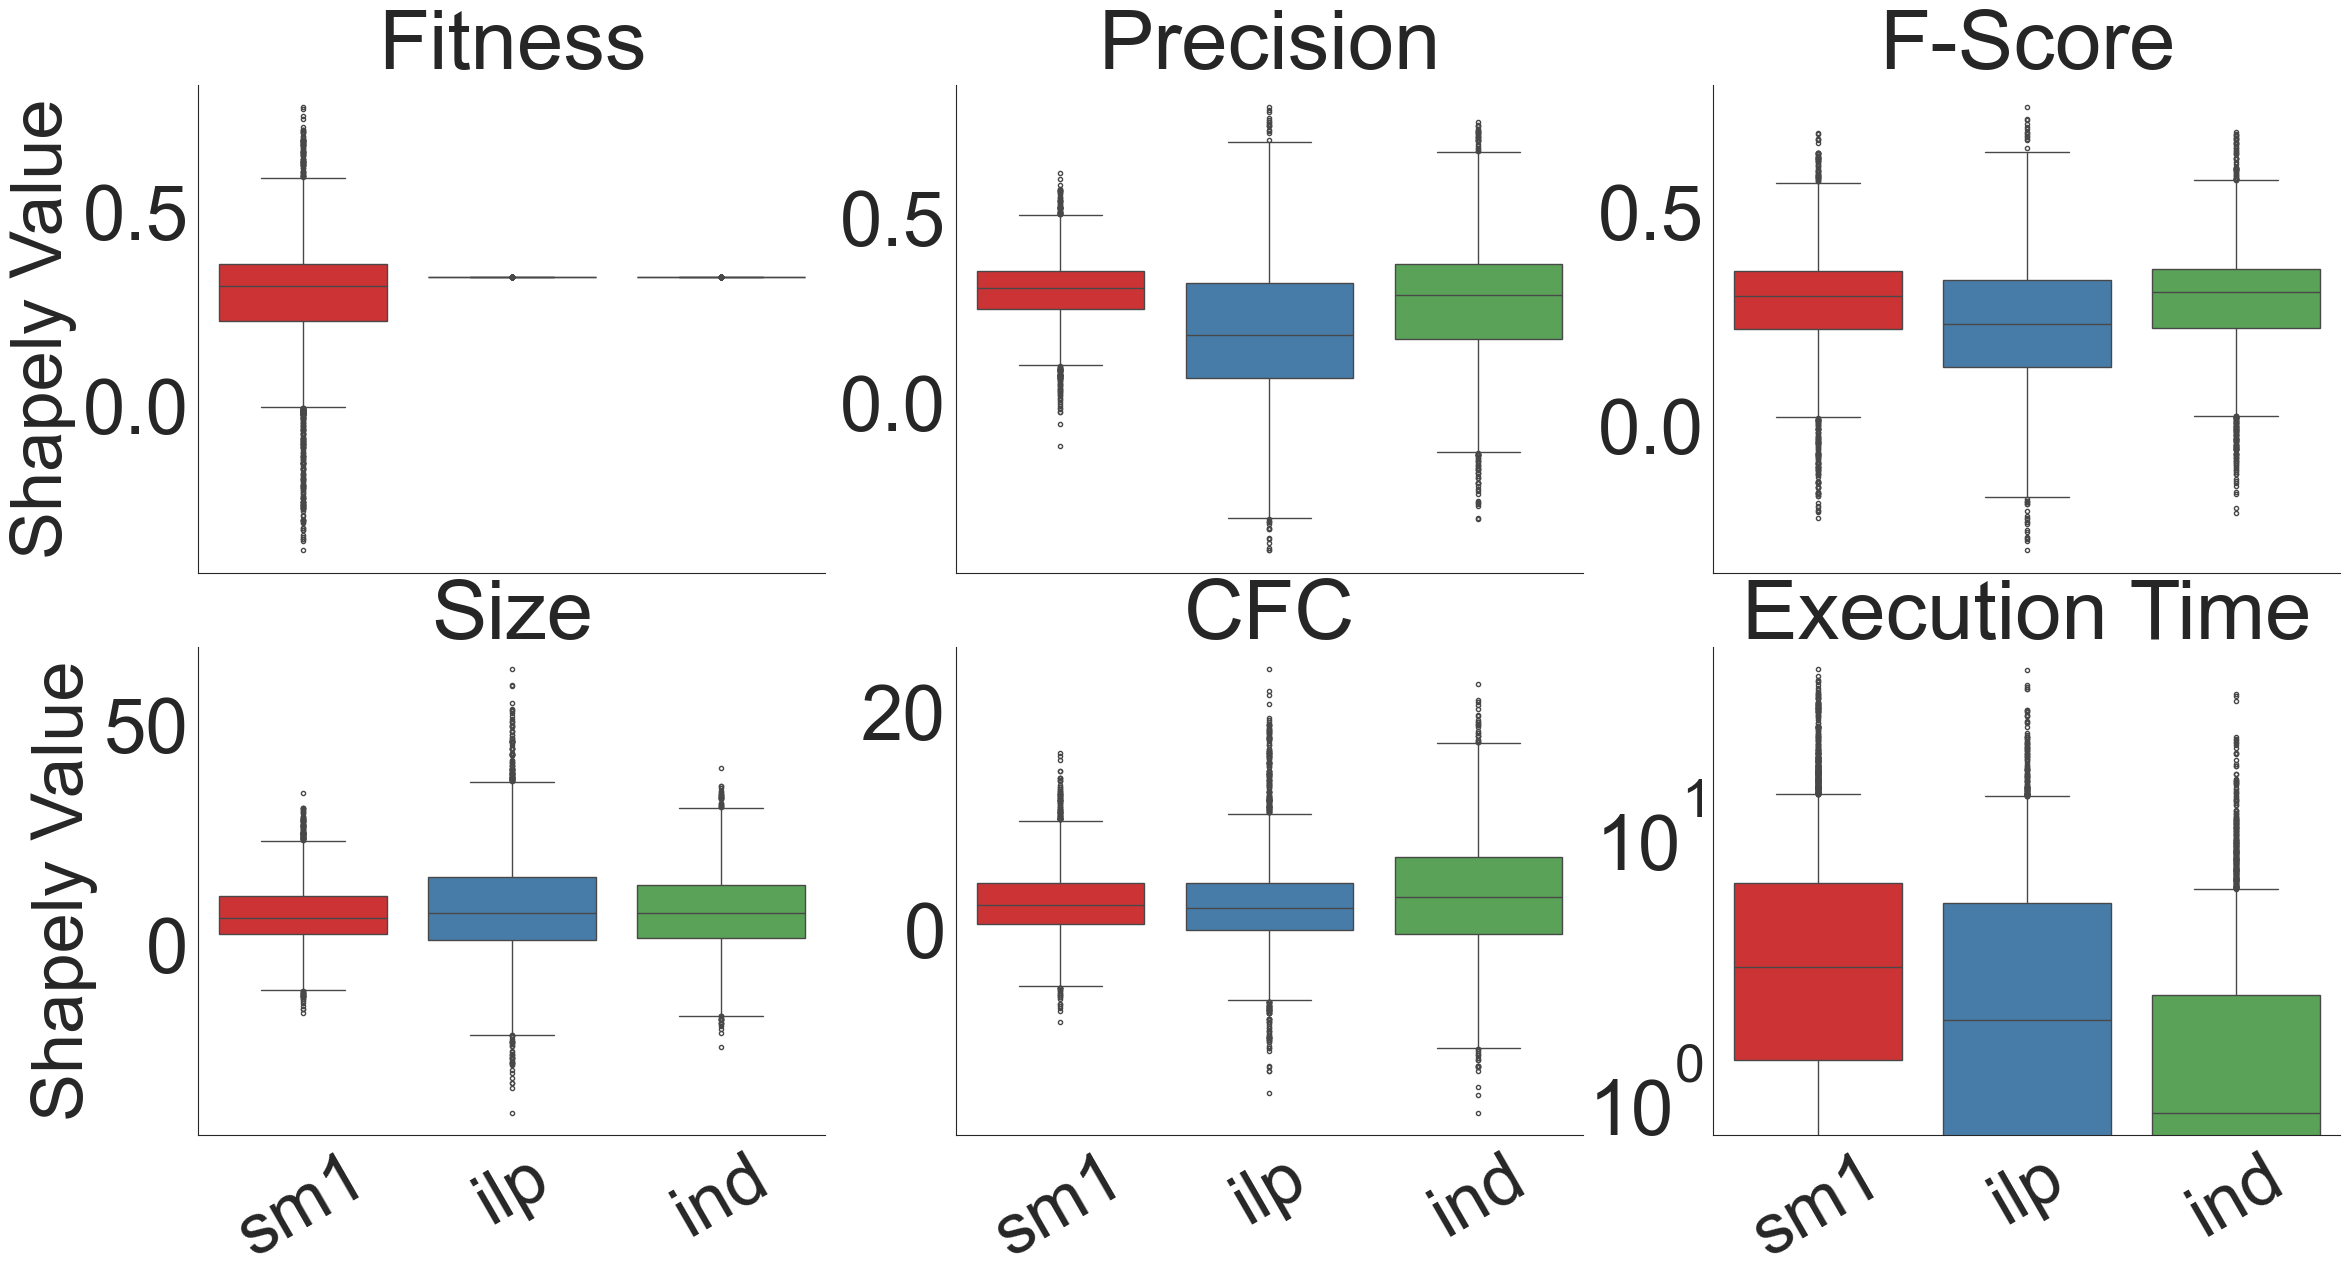

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
INPUT_PATH = "../data/bpm_25/8fts_3miners_ind_ilp_sm1_shapley.csv"
data = pd.read_csv(INPUT_PATH)
# Create subplots
# Set white background
sns.set_style("white")

FONTSIZE = 60
data = pd.read_csv(INPUT_PATH)
df = data.copy()

metrics = ['exectime', 'fitness', 'fscore', 'cfc', 'precision', 'size']
algorithms = ['sm1', 'ilp', 'inductive']

# Create the DataFrame from melted_data
filtered_data = pd.DataFrame(df)

# Define the desired order of metrics with improved names
metric_rename = {
    'fitness': 'Fitness',
    'precision': 'Precision',
    'fscore': 'F-Score',
    'size': 'Size',
    'cfc': 'CFC',
    'exectime': 'Execution Time'
}
metric_order = list(metric_rename.keys())

# Replace "inductive" with "ind" in the Algorithm column
filtered_data["algorithm"] = filtered_data["algorithm"].str.replace("inductive", "ind", regex=False)

# Sort algorithms in the given order
algorithms = ['sm1', 'ilp', 'ind']
filtered_data['algorithm'] = pd.Categorical(filtered_data['algorithm'], categories=algorithms, ordered=True)
filtered_data = filtered_data.sort_values(by='algorithm')

# Remove outliers for 'Execution Time'
exectime_data = filtered_data[filtered_data['metric'] == 'Execution Time']
Q3 = exectime_data['shapley_value'].quantile(0.99)
filtered_exectime_data = exectime_data[exectime_data['shapley_value'] <= Q3]

# Exclude outliers and re-add filtered Execution Time data
filtered_data = filtered_data[filtered_data['metric'] != 'Execution Time']
filtered_data = pd.concat([filtered_data, filtered_exectime_data])

# Rename metrics for better readability
filtered_data["metric"] = filtered_data["metric"].replace(metric_rename)

# Create FacetGrid
g = sns.FacetGrid(filtered_data, col="metric", col_wrap=3, height=7, sharey=False, 
                  col_order=[metric_rename[m] for m in metric_order], aspect=1.2)

# Plot boxplots with improved settings
g.map(sns.boxplot, "algorithm", "shapley_value", palette="Set1", fliersize=3)

# Apply log scale to Execution Time and improve axis formatting
for i, ax in enumerate(g.axes.flat):
    metric_name = ax.get_title().replace("metric = ", "")  
    ax.set_title(metric_name, fontsize=FONTSIZE)

    # Apply log scale for Execution Time
    if metric_name == 'Execution Time':
        ax.set_yscale('log')

    # Remove redundant y-axis labels (only show on first column)
    if i % 3 != 0:
        ax.set_ylabel("")
    else:
        ax.set_ylabel("Shapely Value", fontsize=FONTSIZE-8)

    # Improve x-axis readability
    ax.set_xlabel("")
    ax.tick_params(axis='x', rotation=30, labelsize=FONTSIZE-8)
    ax.tick_params(axis='y', labelsize=FONTSIZE-5)

# Customize layout
g.tight_layout()
g.fig.subplots_adjust(top=0.9, bottom=0.15, left=0.1, right=0.95)

# Show the plot
plt.show()

### Beeswarm plots for impact on fitness for ilp and ind

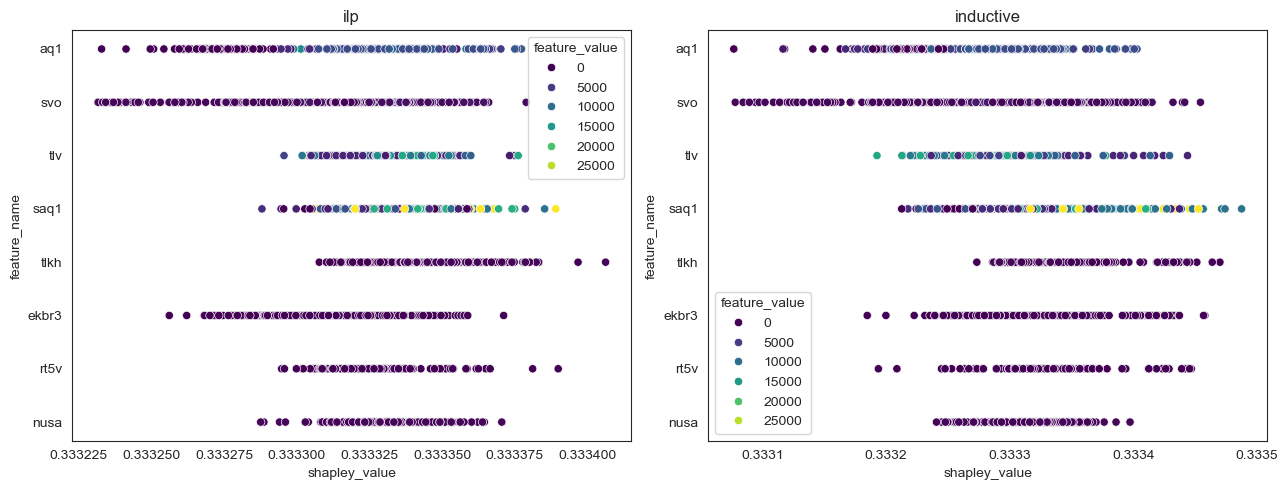

In [5]:
fig, axis = plt.subplots(1, 2, figsize=(13, 5))

# Loop over miners
for id, miner in enumerate(["ilp", "inductive"]):
    temp_data = data[(data["algorithm"] == miner) & (data["metric"] == "fitness")]
    sns.scatterplot(x="shapley_value", y="feature_name", hue ="feature_value", palette="viridis", data=temp_data, ax=axis[id])
    axis[id].set_title(miner)

# Show plot
plt.tight_layout()
plt.show()